In [ ]:
! pip install yfinance

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import os
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, Dropout
import warnings
from tensorflow.keras.utils import get_file
warnings.filterwarnings("ignore")
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.layers import SimpleRNN

In [2]:
def data_to_X_y(temp, window_size=5):
  data_as_np=temp.to_numpy()
  X = []
  y = []
  for i in range(len(data_as_np)-window_size):
    row = [[a] for a in data_as_np[i:i+5]]
    X.append(row)
    label = data_as_np[i+5]
    y.append(label)
  return np.array(X), np.array(y)

In [3]:
def train_test_val_split(X, y):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
  print('Train Set: ', X_train.shape, y_train.shape)
  print('Test Set: ', X_test.shape, y_test.shape)
  return X_train, X_test, y_train, y_test

In [4]:
# Performance Metric
def metric(model, X_test, y_test):
  yhat=model.predict(X_test)
  y=y_test
  from sklearn.metrics import mean_squared_error
  RMSE=mean_squared_error(y, yhat, squared=False )
  MSE= mean_squared_error(y, yhat )
  MAE= mean_absolute_error(y, yhat)
  print('RMSE', RMSE )
  print('MSE', MSE)
  print('MAE', MAE )
  return [RMSE, MSE, MAE]

In [ ]:
score_dict={}

In [5]:
def slice_time_series(data, column_name, window_size, step_size):

    sliced_data = []
    column = data[column_name]
    for i in range(0, len(column) - window_size + 1, step_size):
        window = column[i:i + window_size]
        sliced_data.append(window.values)

    sliced_data = pd.DataFrame(sliced_data, columns=[f"{column_name}_window_{i}" for i in range(window_size)])

    return sliced_data


# **Climate Data**

In [15]:
# Download and load the dataset
zip_path = get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)
data = pd.read_csv(csv_path)

In [ ]:
data.head(2)

In [16]:
window_size = 5
step_size = 5
sliced_data = slice_time_series(data, 'T (degC)', window_size, step_size)
temp = sliced_data['T (degC)_window_0']

In [17]:
WINDOW_SIZE=5
X, y=data_to_X_y(temp, WINDOW_SIZE)
X.shape, y.shape
X_train, X_test, y_train, y_test=train_test_val_split(X, y)

Train Set:  (58873, 5, 1) (58873,)
Test Set:  (25232, 5, 1) (25232,)


## **LSTM**

In [ ]:
model = Sequential()
model.add(LSTM(128, return_sequences=False, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(Dense(24))
model.add(Dense(1))
model.compile(loss = 'mean_squared_error', optimizer='adam')
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), shuffle=False)

Epoch 1/10
1840/1840 [==============================] - 29s 14ms/step - loss: 1.2891 - val_loss: 0.5125
Epoch 2/10
1840/1840 [==============================] - 23s 13ms/step - loss: 0.5561 - val_loss: 0.5063
Epoch 3/10
1840/1840 [==============================] - 26s 14ms/step - loss: 0.5406 - val_loss: 0.4970
Epoch 4/10
1840/1840 [==============================] - 26s 14ms/step - loss: 0.5264 - val_loss: 0.4935
Epoch 5/10
1840/1840 [==============================] - 26s 14ms/step - loss: 0.5154 - val_loss: 0.4848
Epoch 6/10
1840/1840 [==============================] - 24s 13ms/step - loss: 0.5095 - val_loss: 0.4836
Epoch 7/10
1840/1840 [==============================] - 23s 13ms/step - loss: 0.5052 - val_loss: 0.4836
Epoch 8/10
1840/1840 [==============================] - 26s 14ms/step - loss: 0.5032 - val_loss: 0.4817
Epoch 9/10
1840/1840 [==============================] - 23s 13ms/step - loss: 0.5003 - val_loss: 0.4828
Epoch 10/10
1840/1840 [==============================] - 24s 13m

In [ ]:
LSTM_=metric(model, X_test, y_test)
score_dict['LSTM_Climate']= LSTM_

789/789 [==============================] - 5s 5ms/step
RMSE 0.6941967070153823
MSE 0.4819090680310005
MAE 0.46487661207027464


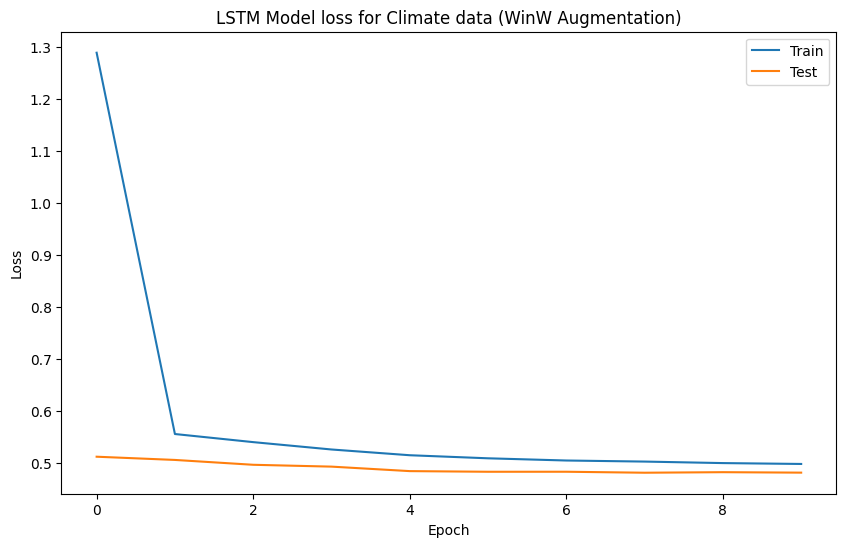

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('LSTM Model loss for Climate data (WinW Augmentation)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

1840/1840 [==============================] - 8s 4ms/step


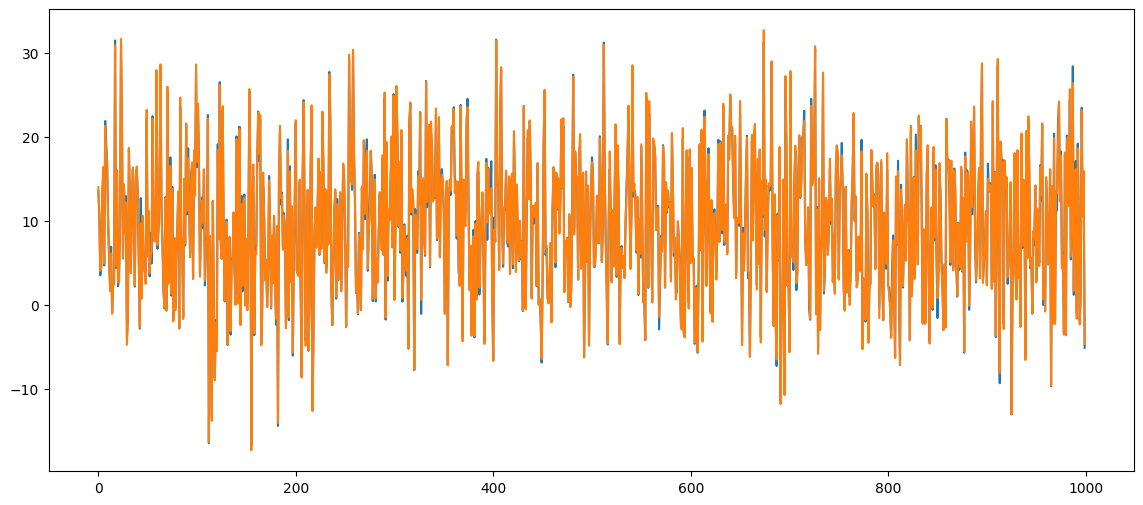

In [ ]:
train_predictions_lstm=model.predict(X_train).flatten()
train_results = pd.DataFrame(data={'Train Predictions': train_predictions_lstm, 'Actuals': y_train})
plt.figure(figsize=(14, 6))
plt.plot(train_results.head(1000)['Train Predictions'])
plt.plot(train_results.head(1000)['Actuals'])

789/789 [==============================] - 4s 5ms/step


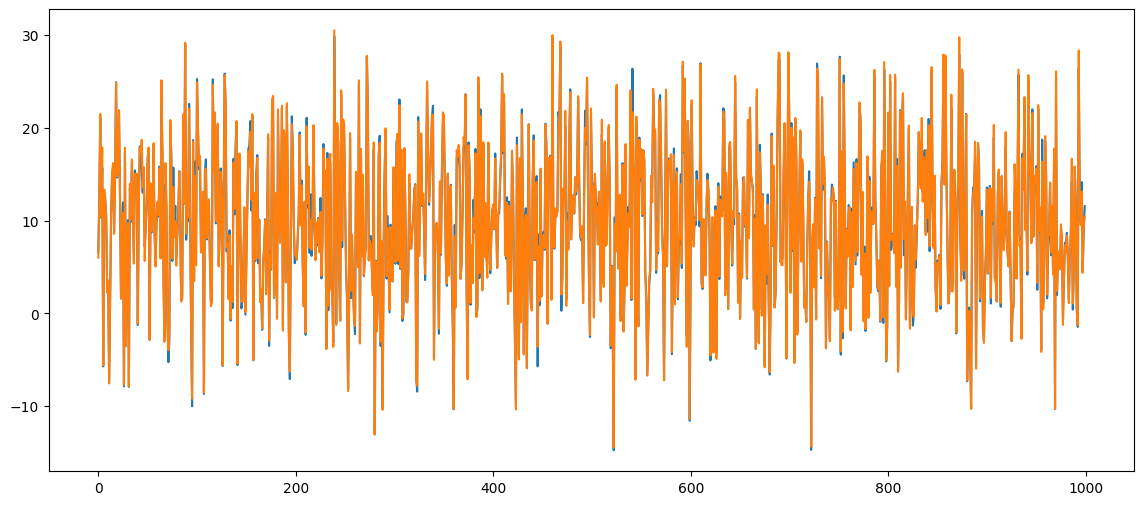

In [ ]:
test_predictions_lstm=model.predict(X_test).flatten()
test_results = pd.DataFrame(data={'Test Predictions': test_predictions_lstm, 'Actuals': y_test})
plt.figure(figsize=(14, 6))
plt.plot(test_results.head(1000)['Test Predictions'])
plt.plot(test_results.head(1000)['Actuals'])

## **RNN**

In [ ]:
# Performance Metric
def metric_(y_test, test_predictions):
  yhat=test_predictions
  y=y_test
  from sklearn.metrics import mean_squared_error
  RMSE=mean_squared_error(y, yhat, squared=False )
  MSE= mean_squared_error(y, yhat )
  MAE= mean_absolute_error(y, yhat)
  print('RMSE', RMSE )
  print('MSE', MSE)
  print('MAE', MAE )
  return [RMSE, MSE, MAE]


# Fit an ARIMA model
import statsmodels.api as sm
p, d, q = 1, 1, 1  # Example values, you may need to adjust these
arima_model = sm.tsa.ARIMA(temp, order=(p, d, q))
# Assuming you have already fitted the ARIMA model
arima_results = arima_model.fit()  # Fit the ARIMA model, you may have different parameters

# Get predictions on the training data
train_predictions_arima = arima_results.predict(start=0, end=len(X_train)-1, typ='levels')  # Adjust start and end accordingly

# Create a DataFrame to store the results
train_results = pd.DataFrame({'Train Predictions': train_predictions_arima, 'Actuals': y_train})

# Get predictions on the training data
test_predictions_arima = arima_results.predict(start=len(X_train), end=len(X_train)+len(X_test)-1, typ='levels')  # Adjust start and end accordingly

# Create a DataFrame to store the results
test_results = pd.DataFrame({'Test Predictions': test_predictions_arima , 'Actuals': y_test})

arima=metric_(y_test, test_predictions_arima  )
score_dict['ARIMA_Climate']= arima



RMSE 11.500780903637809
MSE 132.26796139348008
MAE 9.205866783932965


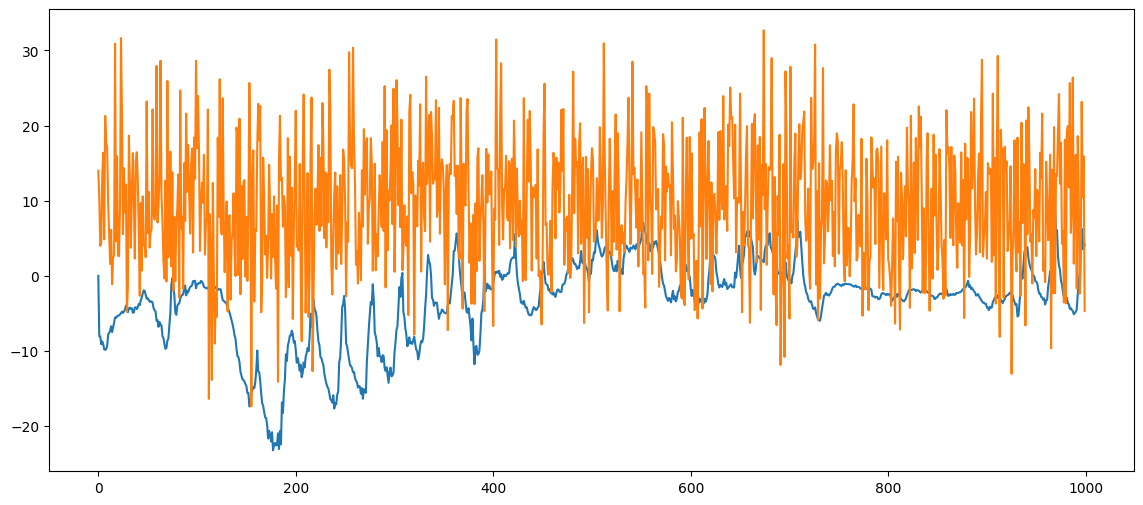

In [ ]:
plt.figure(figsize=(14, 6))
plt.plot(train_results.head(1000)['Train Predictions'])
plt.plot(train_results.head(1000)['Actuals'])

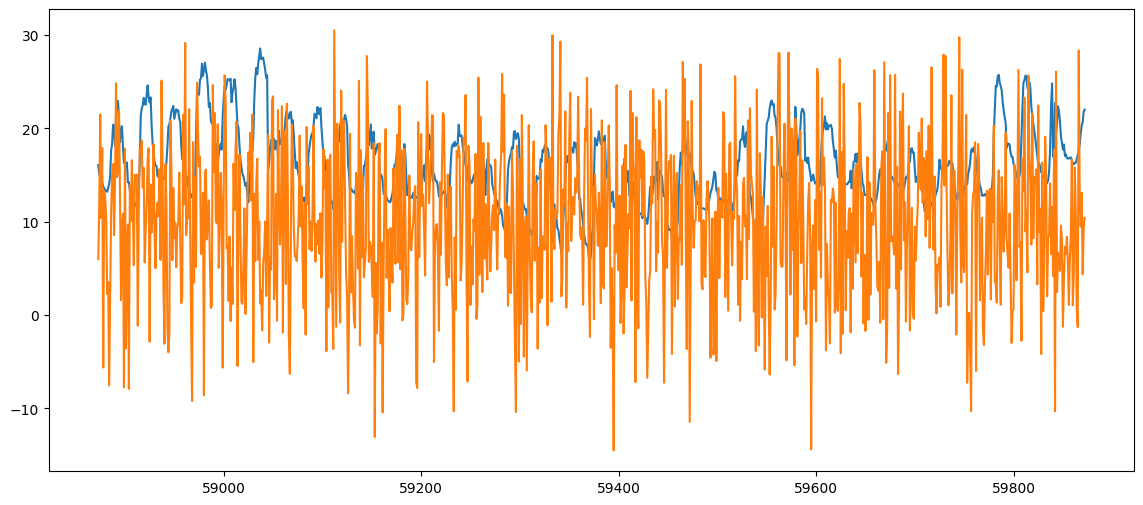

In [ ]:
plt.figure(figsize=(14, 6))
plt.plot(test_results.head(1000)['Test Predictions'])
plt.plot(test_results.head(1000)['Actuals'])

## **Stacking**

In [ ]:
from sklearn.linear_model import LinearRegression
Lr=LinearRegression ()
df_train=pd.DataFrame({'LSTM': train_predictions_lstm, 'RNN': train_predictions_arima})
Lr.fit(df_train, y_train)
df_test=pd.DataFrame({'LSTM': test_predictions_lstm, 'RNN': test_predictions_arima})
stacked_=metric(Lr, df_test, y_test)
score_dict['Stacked_Climate']= stacked_

RMSE 0.6911362171034399
MSE 0.4776692705920532
MAE 0.460552382285507


# **Crypto Dataset (USDT)**

In [ ]:
# Get bitcoin data
data=  yf.Ticker("USDT-USD").history(interval='1d', start='2000-01-01', end='2022-12-31').reset_index()
data.head(2)

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2017-11-09 00:00:00+00:00,1.01087,1.01327,0.996515,1.00818,358188000,0.0,0.0
1,2017-11-10 00:00:00+00:00,1.00650,1.02423,0.995486,1.00601,756446016,0.0,0.0


In [ ]:
data.index = pd.to_datetime(data['Date'], format='%d.%m.%Y %H:%M:%S')

In [ ]:
window_size = 5
step_size = 5
sliced_data = slice_time_series(data, 'Close', window_size, step_size)
usdt = sliced_data['Close_window_0']

In [ ]:
X, y=data_to_X_y(usdt, WINDOW_SIZE)
X.shape, y.shape
X_train, X_test, y_train, y_test=train_test_val_split(X, y)

Train Set:  (259, 5, 1) (259,)
Test Set:  (111, 5, 1) (111,)


## **LSTM**

In [ ]:
model = Sequential()
model.add(LSTM(32, return_sequences=False, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(Dense(1))
model.compile(loss = 'mean_squared_error', optimizer='adam')
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), shuffle=False)

Epoch 1/10
9/9 [==============================] - 3s 58ms/step - loss: 0.6564 - val_loss: 0.5591
Epoch 2/10
9/9 [==============================] - 0s 14ms/step - loss: 0.4936 - val_loss: 0.3993
Epoch 3/10
9/9 [==============================] - 0s 13ms/step - loss: 0.3361 - val_loss: 0.2434
Epoch 4/10
9/9 [==============================] - 0s 10ms/step - loss: 0.1836 - val_loss: 0.1002
Epoch 5/10
9/9 [==============================] - 0s 8ms/step - loss: 0.0569 - val_loss: 0.0099
Epoch 6/10
9/9 [==============================] - 0s 10ms/step - loss: 0.0029 - val_loss: 0.0065
Epoch 7/10
9/9 [==============================] - 0s 9ms/step - loss: 0.0083 - val_loss: 0.0044
Epoch 8/10
9/9 [==============================] - 0s 10ms/step - loss: 0.0017 - val_loss: 1.5878e-04
Epoch 9/10
9/9 [==============================] - 0s 10ms/step - loss: 6.5109e-04 - val_loss: 0.0010
Epoch 10/10
9/9 [==============================] - 0s 10ms/step - loss: 5.5166e-04 - val_loss: 9.6192e-05


In [ ]:
LSTM_=metric(model, X_test, y_test)
score_dict['LSTM_USDT']= LSTM_

4/4 [==============================] - 0s 3ms/step
RMSE 0.00980773632147445
MSE 9.619169175156917e-05
MAE 0.008645258508287035


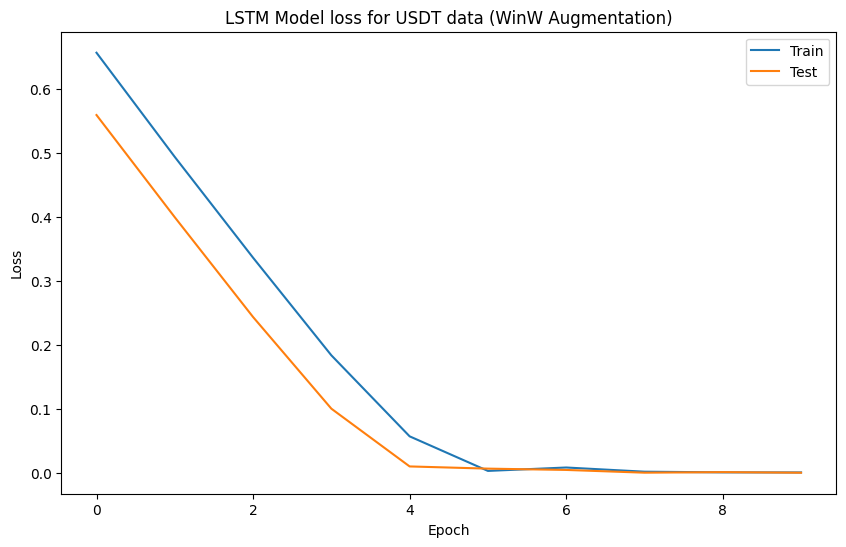

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('LSTM Model loss for USDT data (WinW Augmentation)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

9/9 [==============================] - 0s 3ms/step


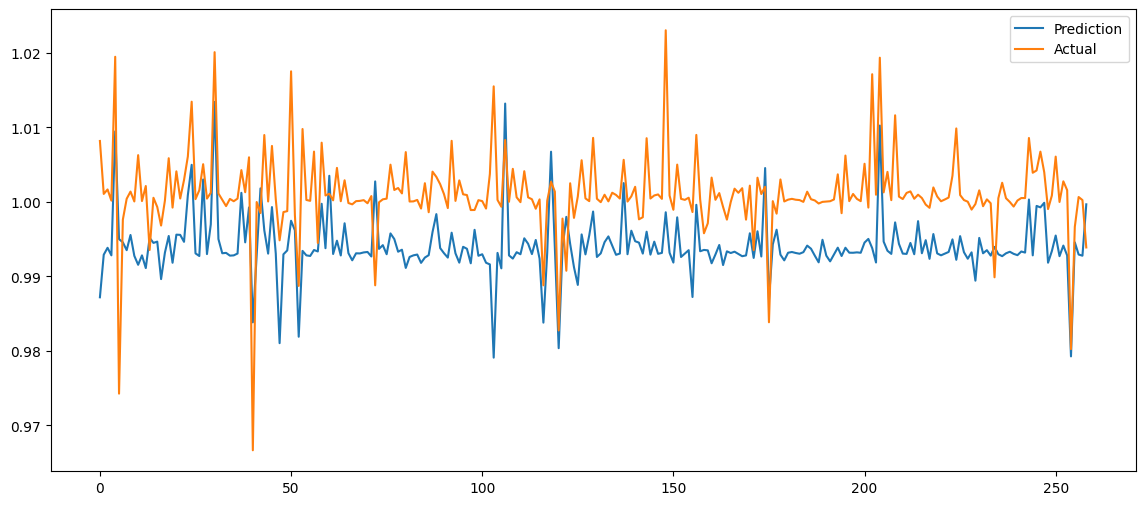

In [ ]:
train_predictions_lstm=model.predict(X_train).flatten()
train_results = pd.DataFrame(data={'Train Predictions': train_predictions_lstm, 'Actuals': y_train})
plt.figure(figsize=(14, 6))
plt.plot(train_results['Train Predictions'], label='Prediction')
plt.plot(train_results['Actuals'], label='Actual')
plt.legend()

4/4 [==============================] - 0s 5ms/step


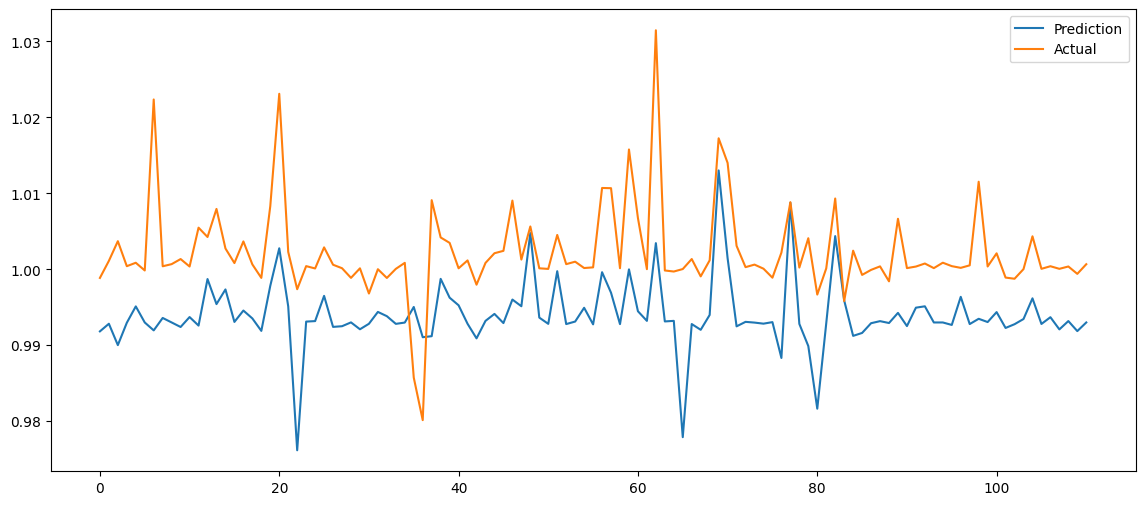

In [ ]:
test_predictions_lstm=model.predict(X_test).flatten()
test_results = pd.DataFrame(data={'Test Predictions': test_predictions_lstm, 'Actuals': y_test})
plt.figure(figsize=(14, 6))
plt.plot(test_results['Test Predictions'], label='Prediction')
plt.plot(test_results['Actuals'], label='Actual')
plt.legend()

## **RNN**

In [ ]:
# Performance Metric
def metric_(y_test, test_predictions):
  yhat=test_predictions
  y=y_test
  from sklearn.metrics import mean_squared_error
  RMSE=mean_squared_error(y, yhat, squared=False )
  MSE= mean_squared_error(y, yhat )
  MAE= mean_absolute_error(y, yhat)
  print('RMSE', RMSE )
  print('MSE', MSE)
  print('MAE', MAE )
  return [RMSE, MSE, MAE]


# Fit an ARIMA model
import statsmodels.api as sm
p, d, q = 1, 1, 1  # Example values, you may need to adjust these
arima_model = sm.tsa.ARIMA(usdt, order=(p, d, q))
# Assuming you have already fitted the ARIMA model
arima_results = arima_model.fit()  # Fit the ARIMA model, you may have different parameters

# Get predictions on the training data
train_predictions_arima = arima_results.predict(start=0, end=len(X_train)-1, typ='levels')  # Adjust start and end accordingly

# Create a DataFrame to store the results
train_results = pd.DataFrame({'Train Predictions': train_predictions_arima, 'Actuals': y_train})

# Get predictions on the training data
test_predictions_arima = arima_results.predict(start=len(X_train), end=len(X_train)+len(X_test)-1, typ='levels')  # Adjust start and end accordingly

# Create a DataFrame to store the results
test_results = pd.DataFrame({'Test Predictions': test_predictions_arima , 'Actuals': y_test})

arima=metric_(y_test, test_predictions_arima  )
score_dict['ARIMA_USDT']= arima

RMSE 0.006404806000864777
MSE 4.102153990871346e-05
MAE 0.0033533094327467543


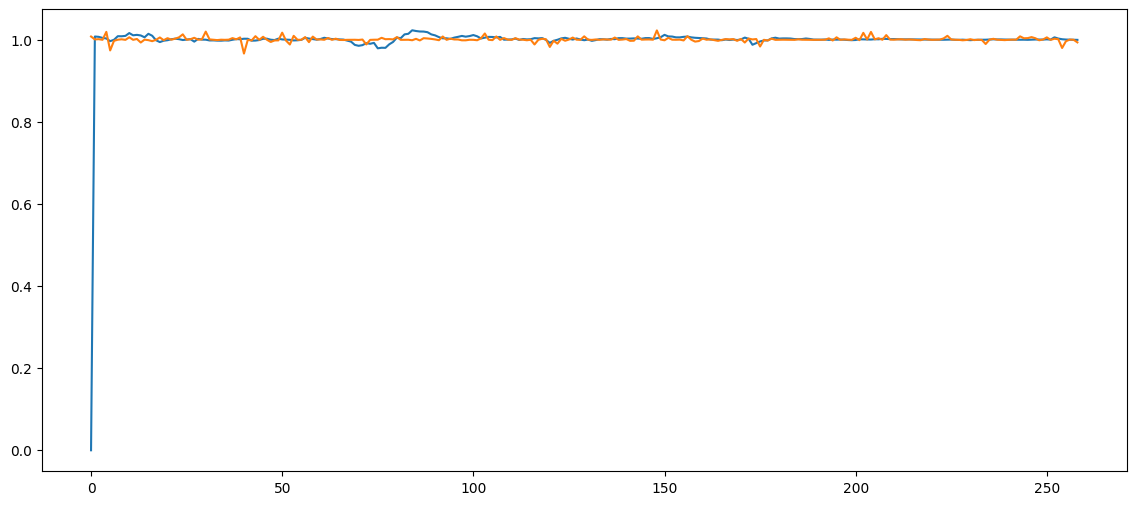

In [ ]:
plt.figure(figsize=(14, 6))
plt.plot(train_results['Train Predictions'])
plt.plot(train_results['Actuals'])

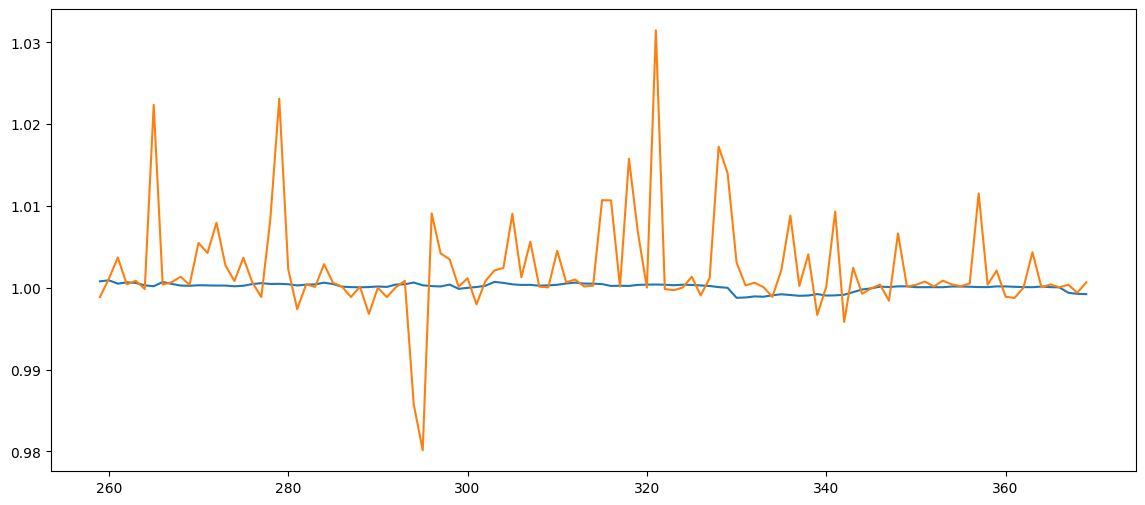

In [ ]:
plt.figure(figsize=(14, 6))
plt.plot(test_results['Test Predictions'])
plt.plot(test_results['Actuals'])

## **Stacking**

In [ ]:
Lr=LinearRegression ()
df_train=pd.DataFrame({'LSTM': train_predictions_lstm, 'RNN': train_predictions_arima})
Lr.fit(df_train, y_train)
df_test=pd.DataFrame({'LSTM': test_predictions_lstm, 'RNN': test_predictions_arima})
stacked_=metric(Lr, df_test, y_test)
score_dict['Stacked_USDT']= stacked_

RMSE 0.005276896041537155
MSE 2.78456318331905e-05
MAE 0.0027228951136915257


# **Plant Sensor Data**

In [ ]:
df=pd.read_csv('/content/drive/MyDrive/measures.csv')
df.head()

,mp,temperature,humidity,moisture,light,date,time
0,n1,24.7,57.9,1995,0.0,2022-09-15,00:00:04
1,n1,24.7,58.0,1991,0.0,2022-09-15,00:00:09
2,n1,24.7,58.2,1994,0.0,2022-09-15,00:00:14
3,n1,24.6,58.0,1993,0.0,2022-09-15,00:00:19
4,n1,24.6,58.0,1986,0.0,2022-09-15,00:00:25


In [ ]:
df.date=pd.to_datetime(df['date'] + ' ' + df['time'])
df.index = pd.to_datetime(df['date'], format='%d.%m.%Y %H:%M:%S')

In [ ]:
window_size = 5
step_size = 5
sliced_data = slice_time_series(df, 'humidity', window_size, step_size)
humidity = sliced_data['humidity_window_0']

In [ ]:
WINDOW_SIZE=5
X, y=data_to_X_y(humidity, WINDOW_SIZE)
X.shape, y.shape
X_train, X_test, y_train, y_test=train_test_val_split(X, y)

Train Set:  (32753, 5, 1) (32753,)
Test Set:  (14038, 5, 1) (14038,)


## **LSTM**

In [ ]:
model = Sequential()
model.add(LSTM(16, return_sequences=False, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(Dense(1))
model.compile(loss = 'mean_squared_error', optimizer='adam')
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), shuffle=False)

Epoch 1/10
1024/1024 [==============================] - 9s 7ms/step - loss: 52.2749 - val_loss: 0.2530
Epoch 2/10
1024/1024 [==============================] - 5s 5ms/step - loss: 0.2694 - val_loss: 0.2668
Epoch 3/10
1024/1024 [==============================] - 6s 6ms/step - loss: 0.2627 - val_loss: 0.2706
Epoch 4/10
1024/1024 [==============================] - 7s 7ms/step - loss: 0.2616 - val_loss: 0.2738
Epoch 5/10
1024/1024 [==============================] - 6s 6ms/step - loss: 0.2610 - val_loss: 0.2737
Epoch 6/10
1024/1024 [==============================] - 6s 6ms/step - loss: 0.2609 - val_loss: 0.2673
Epoch 7/10
1024/1024 [==============================] - 7s 7ms/step - loss: 0.2613 - val_loss: 0.2614
Epoch 8/10
1024/1024 [==============================] - 6s 6ms/step - loss: 0.2622 - val_loss: 0.2557
Epoch 9/10
1024/1024 [==============================] - 7s 7ms/step - loss: 0.2627 - val_loss: 0.2518
Epoch 10/10
1024/1024 [==============================] - 6s 6ms/step - loss: 0.26

In [ ]:
LSTM_=metric(model, X_test, y_test)
score_dict['LSTM_Humidty']= LSTM_

439/439 [==============================] - 1s 2ms/step
RMSE 0.5006673109300954
MSE 0.25066775623397286
MAE 0.34399262041188927


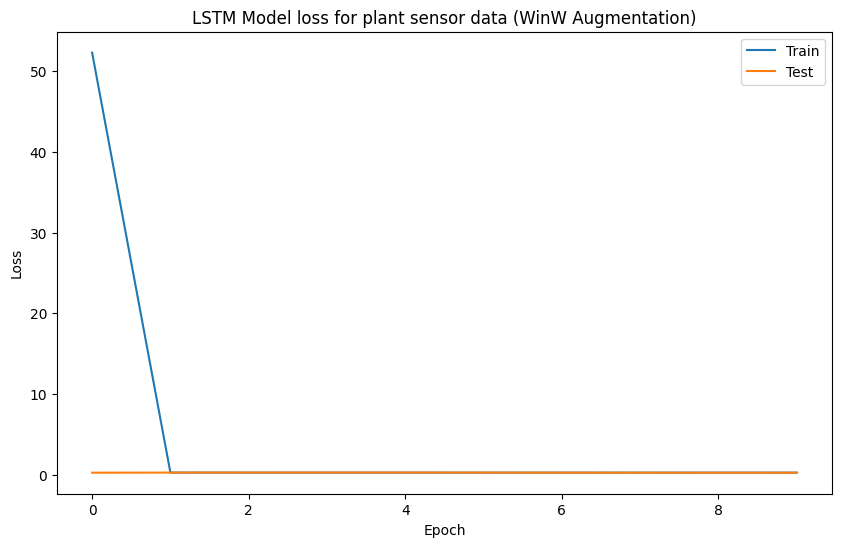

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('LSTM Model loss for plant sensor data (WinW Augmentation)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

1024/1024 [==============================] - 2s 2ms/step


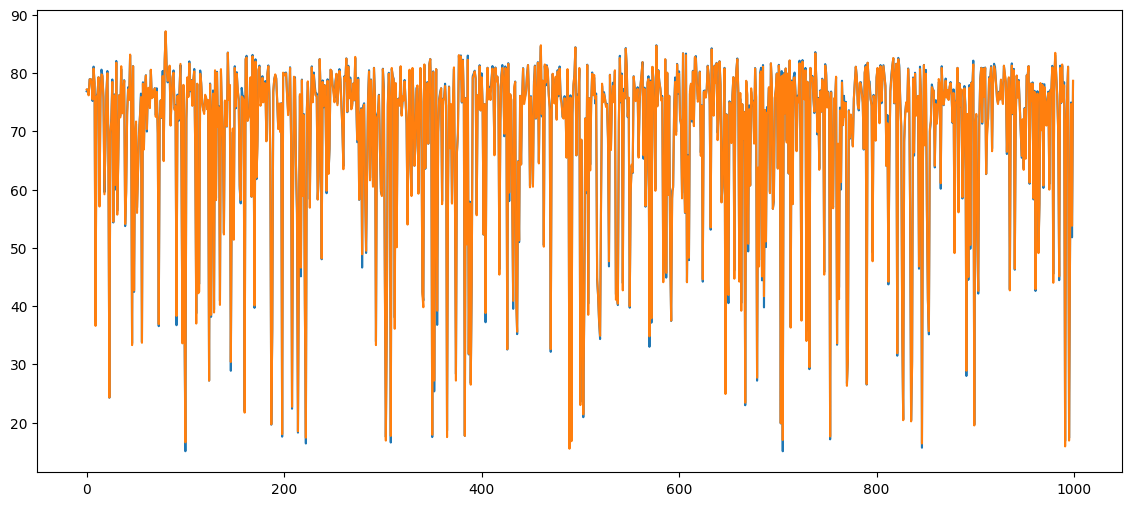

In [ ]:
train_predictions_lstm=model.predict(X_train).flatten()
train_results = pd.DataFrame(data={'Train Predictions': train_predictions_lstm, 'Actuals': y_train})
plt.figure(figsize=(14, 6))
plt.plot(train_results.head(1000)['Train Predictions'])
plt.plot(train_results.head(1000)['Actuals'])

439/439 [==============================] - 2s 4ms/step


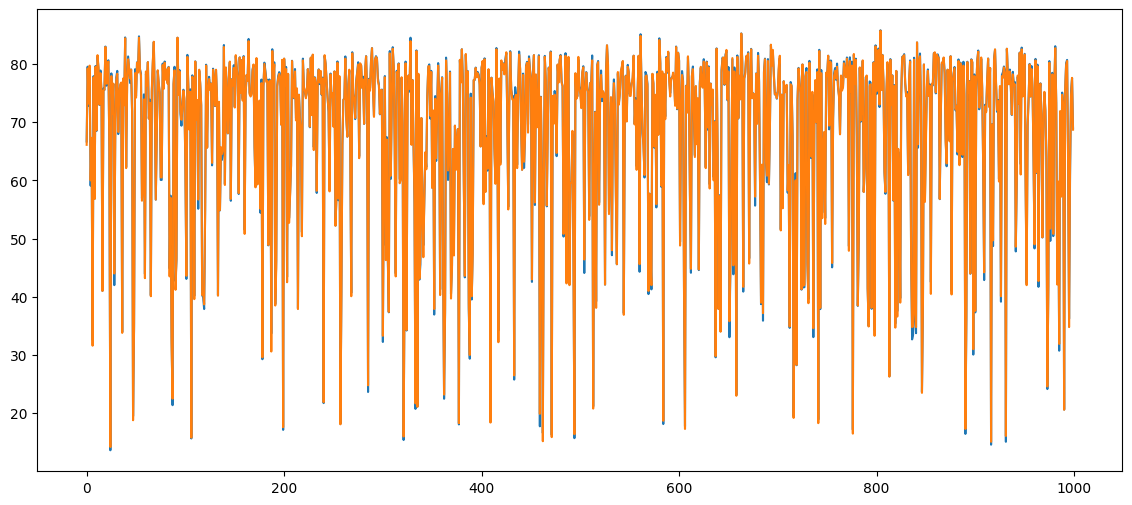

In [ ]:
test_predictions_lstm=model.predict(X_test).flatten()
test_results = pd.DataFrame(data={'Test Predictions': test_predictions_lstm, 'Actuals': y_test})
plt.figure(figsize=(14, 6))
plt.plot(test_results.head(1000)['Test Predictions'])
plt.plot(test_results.head(1000)['Actuals'])

## **RNN**

In [ ]:
# Performance Metric
def metric_(y_test, test_predictions):
  yhat=test_predictions
  y=y_test
  from sklearn.metrics import mean_squared_error
  RMSE=mean_squared_error(y, yhat, squared=False )
  MSE= mean_squared_error(y, yhat )
  MAE= mean_absolute_error(y, yhat)
  print('RMSE', RMSE )
  print('MSE', MSE)
  print('MAE', MAE )
  return [RMSE, MSE, MAE]


# Fit an ARIMA model
import statsmodels.api as sm
p, d, q = 1, 1, 1  # Example values, you may need to adjust these
arima_model = sm.tsa.ARIMA(humidity, order=(p, d, q))
# Assuming you have already fitted the ARIMA model
arima_results = arima_model.fit()  # Fit the ARIMA model, you may have different parameters

# Get predictions on the training data
train_predictions_arima = arima_results.predict(start=0, end=len(X_train)-1, typ='levels')  # Adjust start and end accordingly

# Create a DataFrame to store the results
train_results = pd.DataFrame({'Train Predictions': train_predictions_arima, 'Actuals': y_train})

# Get predictions on the training data
test_predictions_arima = arima_results.predict(start=len(X_train), end=len(X_train)+len(X_test)-1, typ='levels')  # Adjust start and end accordingly

# Create a DataFrame to store the results
test_results = pd.DataFrame({'Test Predictions': test_predictions_arima , 'Actuals': y_test})

arima=metric_(y_test, test_predictions_arima  )
score_dict['ARIMA_Humidity']= arima

RMSE 18.498161573129078
MSE 342.18198158558926
MAE 12.175938298098814


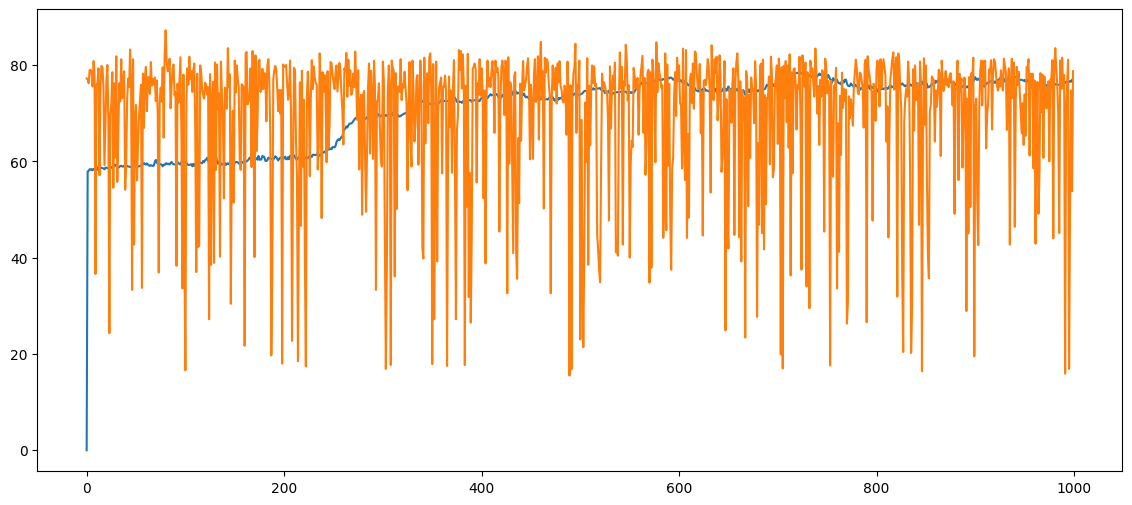

In [ ]:
plt.figure(figsize=(14, 6))
plt.plot(train_results.head(1000)['Train Predictions'])
plt.plot(train_results.head(1000)['Actuals'])

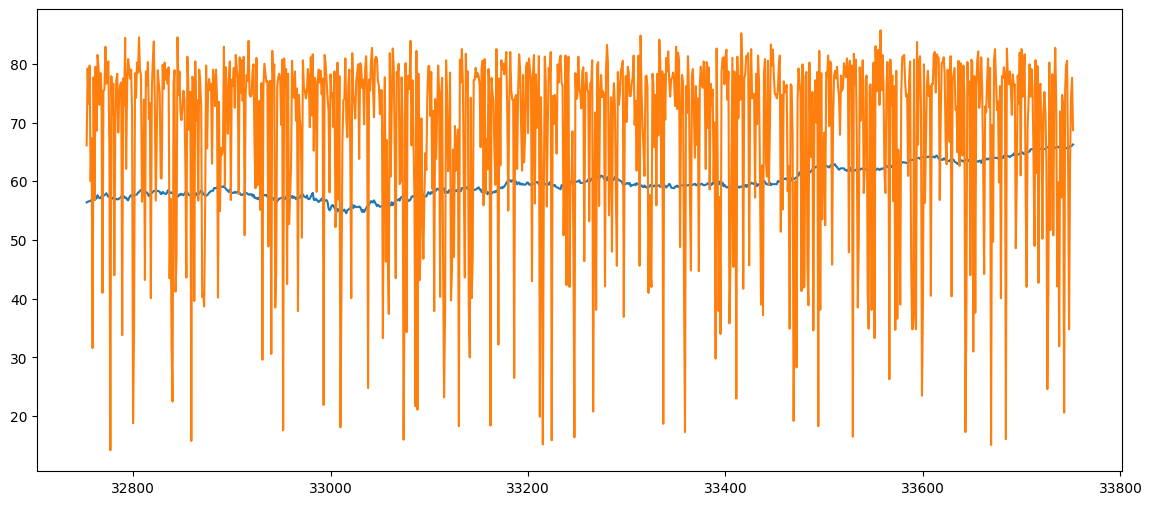

In [ ]:
plt.figure(figsize=(14, 6))
plt.plot(test_results.head(1000)['Test Predictions'])
plt.plot(test_results.head(1000)['Actuals'])

## **Stacking**

In [ ]:
from sklearn.linear_model import LinearRegression
Lr=LinearRegression ()
df_train=pd.DataFrame({'LSTM': train_predictions_lstm, 'RNN': train_predictions_arima})
Lr.fit(df_train, y_train)
df_test=pd.DataFrame({'LSTM': test_predictions_lstm, 'RNN': test_predictions_arima})
stacked_=metric(Lr, df_test, y_test)
score_dict['Stacked_Humidity']= stacked_

RMSE 0.49062252028508274
MSE 0.24071045741088645
MAE 0.3321752985852236


# **Results**

In [ ]:
Result=pd.DataFrame(score_dict).T
Result.columns=['RMSE', 'MSE', 'MAE']
Result[ 'Dat']=Result.index.str.split('_')
Result['Data']=Result[ 'Dat'].str[1]
Result['Model']=Result['Dat'].str[0]
Result.drop('Dat', axis=1, inplace=True)
Result=Result.set_index('Data')
Result=Result[['Model', 'RMSE', 'MSE', 'MAE']]
Result.to_csv('/content/drive/MyDrive/New TS DA/WinW_Augmentation.csv')